# Time Required to Read all Books in my list

## Introduction

This is a fun short project to estimate the time I need to read all the books I have in my reading list.
I use Asana to organize my books list in Kanban'ish board, starting with books I "May Read Someday", "Books to Read Next" and "Currently Reading", then specialised lists for work-related books that I usually read in parallel with the other books:

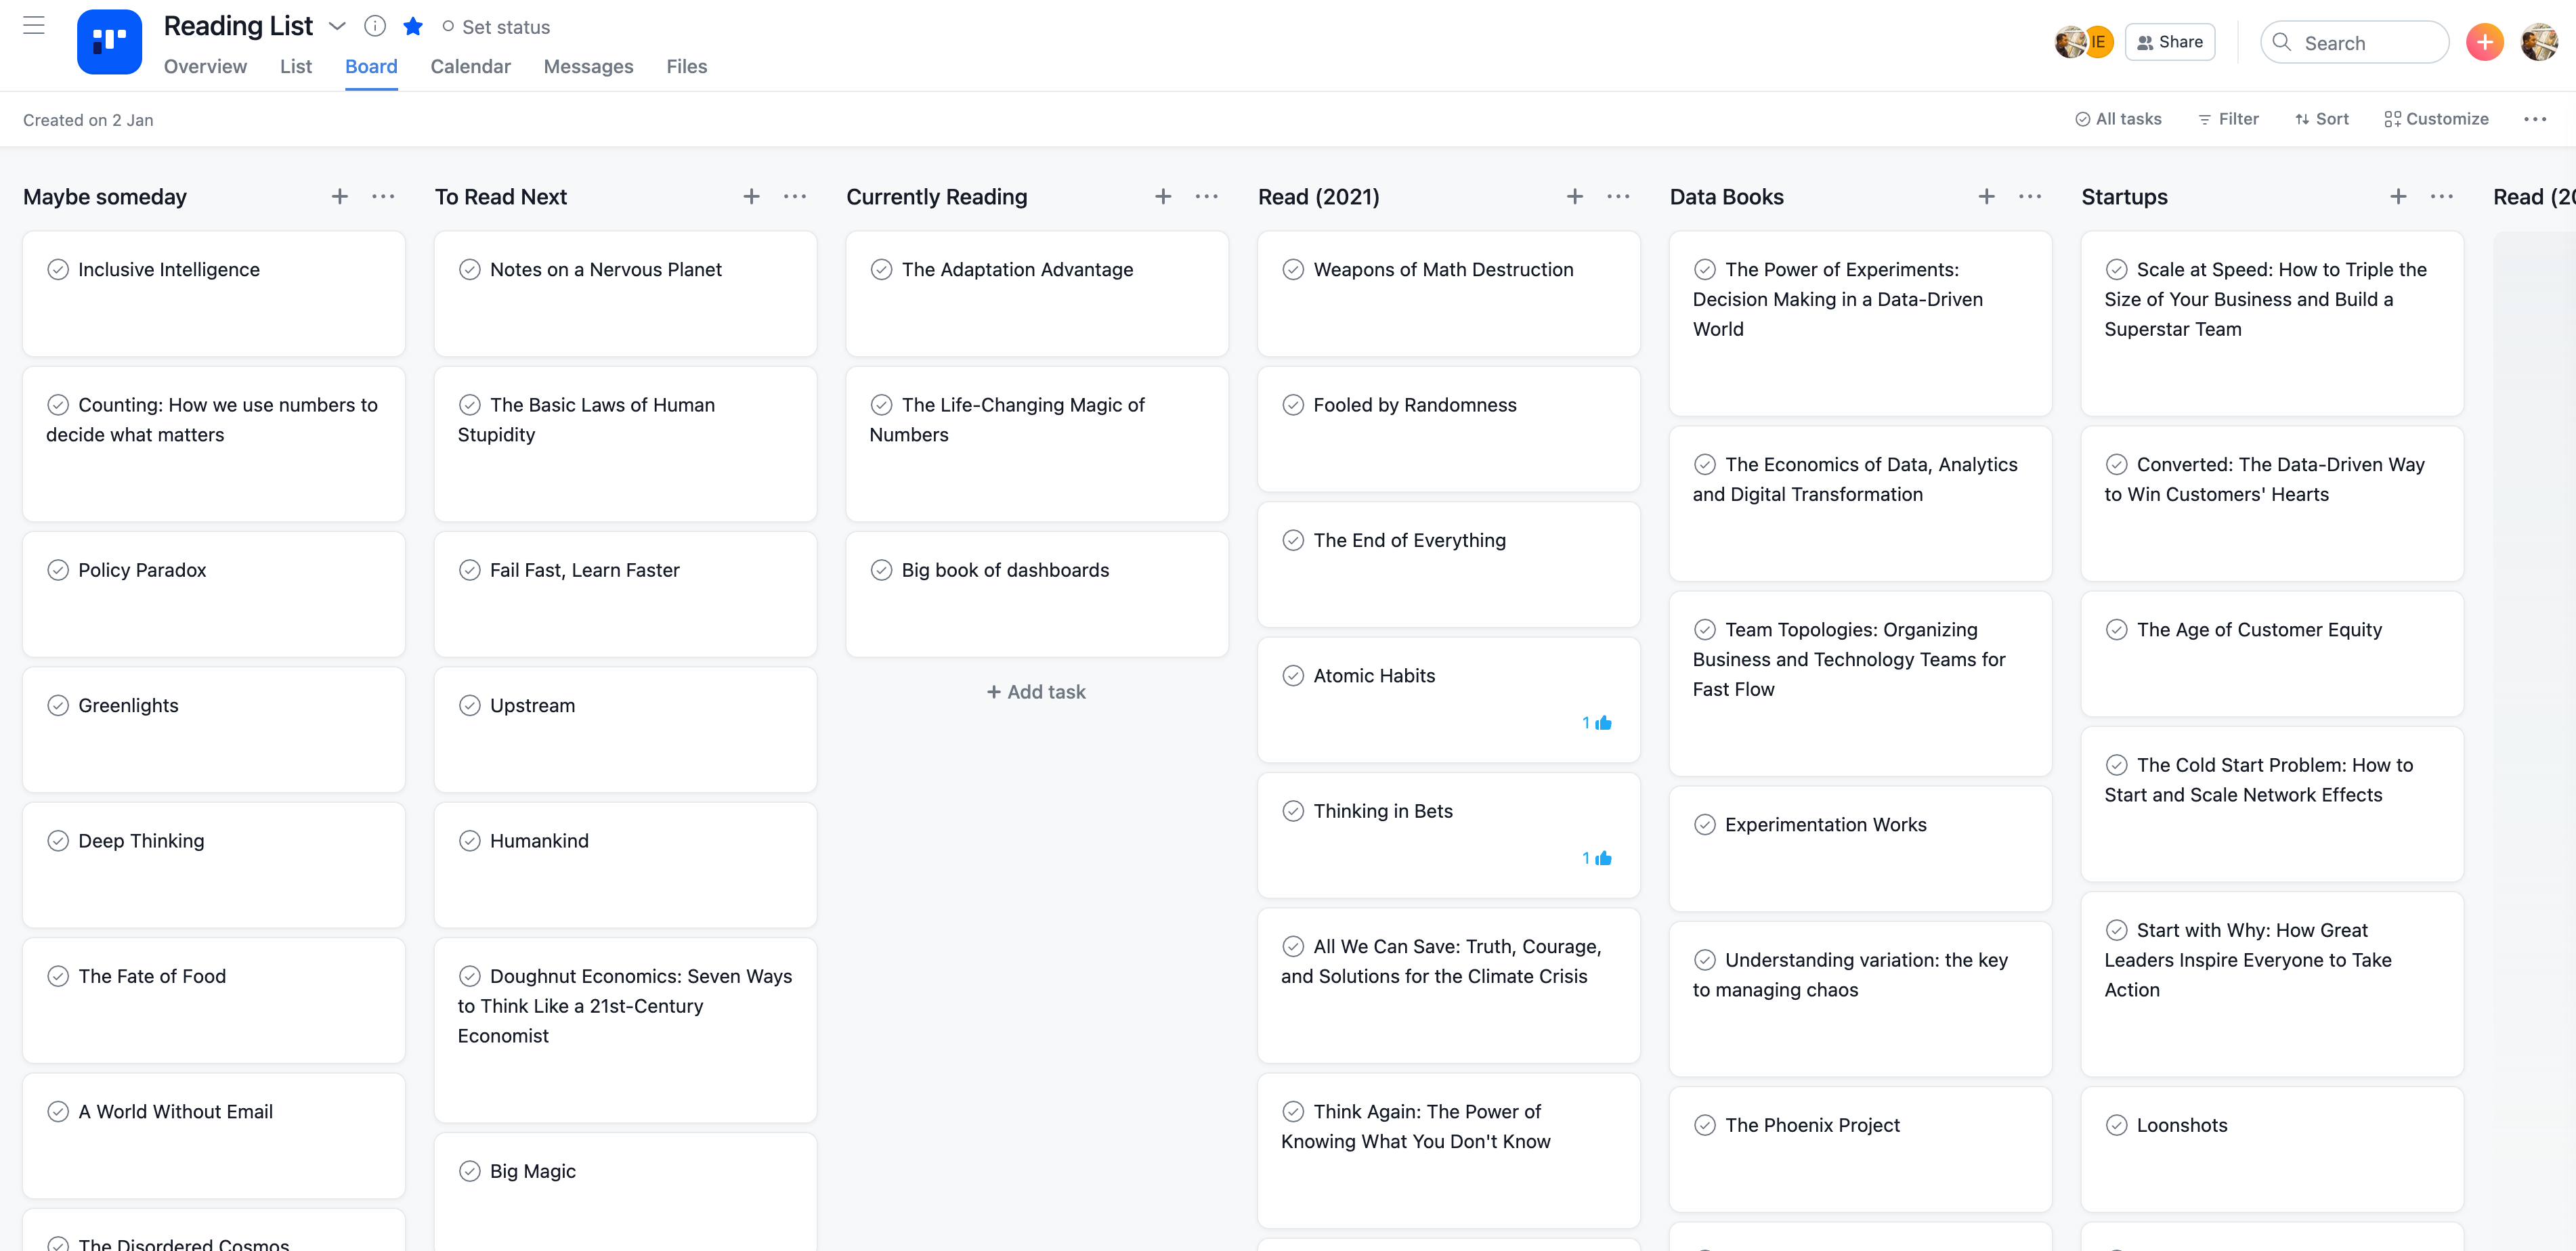

I used Asana's API to get the books list into Pandas, then used Google Books API to get the count of pages for each book. Then subtracted the total by 3% for front and back matter that I usually skip, and ended up with 295,229 pages that I should read!


## Prerequisites

We'll need to access the cards on Asana, so we'll use [Asana's API](https://developers.asana.com/docs) to get the list of all cards in the project.
First, you'll need to install Asana's package:

<div class="alert alert-block alert-success">
pip install asana
</div>

Then we need to generate [Personal Access Token](https://developers.asana.com/docs/personal-access-token) , and get the project ID. You can find the project ID simply by looking at the URL of the project that would usually look like this: app.asana.com/0/<b>project_id</b>/board 

I stored both as environment variables: personal_access_token & project_id.

Next, we need to make sure we have pandas installed:

<div class="alert alert-block alert-success">
pip install pandas
</div>

## Installing dependencies

In [ ]:
import asana
import pandas as pd    
import requests

## Get the tasks list into Pandas DataFrame:

Create a client using your Asana Personal Access Token:

In [ ]:
client = asana.Client.access_token(personal_access_token)

Then get the cards list:

In [ ]:
tasks = client.tasks.get_tasks_for_project(project_id, opt_pretty=True)

Asana's API return the list of cards as Python Generator object, which is a lazy-evaluating abstraction around sets of items. So I had force it to fetch all items by castimg to list:

In [ ]:
list_of_tasks = list(tasks)

This turns it into list of dictionaries that includes card ID, name and resource type:
{'gid': '1198988981073797',
  'name': 'Inclusive Intelligence ',
  'resource_type': 'task'}

Then I looped through the list to extarct each item, store it in Pandas DF then exclude IDs and resource type. I'm sure there is smarter way to do that but couldn't figure it out:

In [ ]:
myList = []

for dict_item in list_of_tasks:
  for key in dict_item:
    myList.append(str(dict_item[key]))

In [ ]:
df = pd.DataFrame (myList, columns = ['books'])

Exclude numbers in dataframe:

In [ ]:
df = df[~df['books'].str.contains('^\d+$')]

Exclude repotitive resource type:

In [ ]:
df = df[df.books != 'task']

## Use Google Books API to get the pages count:

Next I needed an API to submit book name and get pages count returned. I tried the [Open Library](https://openlibrary.org/dev/docs/api/books) but it wasn't efficient becasue not all cards had the extact title of the book. So I ended up using [Google Books API](https://developers.google.com/books/docs/v1/using) which returns a list of best matches, and that worked perfectly with my cards.

Google Books API supports two types of credentials: OAuth 2.0 & API keys. I used the API key that you can generate from GCP console. Make sure you enable the Books API service for the GCP project.

This program use Pandas .apply method to apply the function on each raw, passing the book title then getting information of the first result from the API's request:

In [ ]:
%%time

def extract_book_info(book_title):
    title, pageCount, categories = None, None, None
    api_key = GOOGLE_API_KEY
    base_url = "https://www.googleapis.com/books/v1/volumes"
    endpoint = f"{base_url}?q={book_title}&key={api_key}"
    # see how our endpoint includes our API key? Yes this is yet another reason to restrict the key
    r = requests.get(endpoint)
    if r.status_code not in range(200, 299):
        return None, None, None
    try:
        '''
        This try block incase any of our inputs are invalid. This is done instead
        of actually writing out handlers for all kinds of responses.
        '''
        results = r.json()
        title = results['items'][0]['volumeInfo']['title']
        pageCount = results['items'][0]['volumeInfo']['pageCount']
        categories = results['items'][0]['volumeInfo']['categories'][0]
    except:
        pass
    return title, pageCount, categories
    
def get_book_info(row):
    column_name = 'books'
    book_name = row[column_name]
    title, pageCount, categories = extract_book_info(book_name)
    row['title'] = title
    row['pageCount'] = pageCount
    row['categories'] = categories
    return row

books_with_info = df.apply(get_book_info, axis=1)

I found it also interesting to get the categories of the books for future analysis, and I usually like to check the time when having external API calls so I used the magic command %%time.

Then we end up with a pandas dataframe with pageCount and categories (used only first category here):

In [ ]:
books_with_info

## Doing Final calculations:

I need usually 2 minutes per page. Assuming that I spend 8 hours per week for reading, then each month I have 32 hours.

Then the total years required could be calculated by:

(total pages count)/60 -> to get time in hours then /32 -> to get per month then /12 -> to

In [ ]:
total_pageCount = books_with_info['pageCount'].sum()

In [ ]:
total_years = total_pageCount/60/32/12

## Join the conversation:

I found that I need <b>26 years</b> to read all the books I have in my list, assuming that I'm not adding new books in the future!
I find it quite disappointing to live with the fact that I'll never be able to read all the books that I want and learn all the things that I want. If you have any thoughts on how to deal with it, join [the convesation here](https://www.linkedin.com/feed/update/urn:li:activity:6855483722737741824/).